# Startup Success Prediction: Advanced Preprocessing & Modeling

This notebook performs comprehensive data preprocessing with feature selection and engineering, followed by SVM and Decision Tree modeling with hyperparameter tuning.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings

sns.set()
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the data
# Adjust the path to your actual file location
df = pd.read_csv('/content/drive/My Drive/companies.csv')
print(f"Data loaded with shape: {df.shape}")

Data loaded with shape: (196553, 44)


## 1. Initial Data Cleaning

In [4]:
# 1.b. Delete redundant columns
cols_to_drop = ['id', 'Unnamed: 0.1', 'entity_type', 'entity_id', 'parent_id',
                'created_by', 'created_at', 'updated_at']
cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df = df.drop(columns=cols_to_drop)
print(f"Shape after dropping redundant columns: {df.shape}")

Shape after dropping redundant columns: (196553, 36)


In [5]:
# 1.a. Delete columns with too much granularity
granular_cols = ['region', 'city', 'domain', 'homepage_url', 'twitter_username',
                 'logo_url', 'logo_width', 'logo_height', 'short_description',
                 'description', 'overview', 'tag_list', 'name', 'normalized_name',
                 'permalink', 'invested_companies']
granular_cols = [col for col in granular_cols if col in df.columns]
df = df.drop(columns=granular_cols)
print(f"Shape after dropping granular columns: {df.shape}")

Shape after dropping granular columns: (196553, 20)


In [6]:
# 1.d. Remove duplicate rows
print(f"Number of duplicates: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Shape after removing duplicates: {df.shape}")

Number of duplicates: 86929
Shape after removing duplicates: (109624, 20)


In [7]:
# 1.e. Remove columns with >98% null values
null_ratio = df.isnull().mean()
cols_to_drop_null = null_ratio[null_ratio > 0.98].index.tolist()
print(f"Columns with >98% null values: {cols_to_drop_null}")
df = df.drop(columns=cols_to_drop_null)
print(f"Shape after dropping high null columns: {df.shape}")

Columns with >98% null values: ['ROI']
Shape after dropping high null columns: (109624, 19)


## 2. Handle Missing Values

In [8]:
# 1.a. Delete rows with critical missing values
critical_cols = ['status', 'country_code', 'category_code', 'founded_at']
critical_cols = [col for col in critical_cols if col in df.columns]
df = df.dropna(subset=critical_cols)
print(f"Shape after dropping rows with critical nulls: {df.shape}")

Shape after dropping rows with critical nulls: (63616, 19)


In [9]:
# Impute numerical columns with median
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

# Impute categorical columns with mode
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
        df[col] = df[col].fillna(mode_val)

print("Missing values after imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Missing values after imputation:
Series([], dtype: int64)


## 3. Date Processing

In [10]:
# Convert date columns to datetime
date_columns = ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at',
                'first_milestone_at', 'last_milestone_at']

for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# 2.b.i Replacing the values in closed_at column
# Note: The markdown is slightly confusing here as 'closed_at' column was dropped earlier.
# We'll work with what's available in the dataset
if 'closed_at' in df.columns and 'status' in df.columns:
    # Set closed_at to 2021 for operating/ipo companies
    df.loc[df['status'].isin(['operating', 'ipo']), 'closed_at'] = pd.to_datetime('2021-01-01')

    # Set closed_at to founded_at for acquired/closed companies (will result in 0 days)
    mask = df['status'].isin(['acquired', 'closed'])
    df.loc[mask, 'closed_at'] = df.loc[mask, 'founded_at']

In [11]:
# 2.b.ii Calculate active days
if 'founded_at' in df.columns and 'closed_at' in df.columns:
    # Calculate active days
    df['active_days'] = (df['closed_at'] - df['founded_at']).dt.days

    # Check for contradictory issues (negative active days)
    contradictions = df['active_days'] < 0
    print(f"Contradictory records (negative active days): {contradictions.sum()}")

    # Set negative active days to 0
    df.loc[contradictions, 'active_days'] = 0

    # 2.b.iii Delete the closed_at column
    df = df.drop(columns=['closed_at'])

    print(f"Shape after date processing: {df.shape}")

Contradictory records (negative active days): 0
Shape after date processing: (63616, 19)


## 4. Feature Engineering

In [12]:
# Create 'isClosed' target variable
if 'status' in df.columns:
    df['isClosed'] = df['status'].apply(lambda x: 1 if x in ['acquired', 'closed'] else 0)

    # Create additional features
    if 'funding_total_usd' in df.columns and 'funding_rounds' in df.columns:
        # Funding efficiency
        df['funding_per_round'] = df['funding_total_usd'] / (df['funding_rounds'] + 1)

    if 'milestones' in df.columns and 'funding_rounds' in df.columns:
        # Milestone efficiency
        df['milestones_per_funding_round'] = df['milestones'] / (df['funding_rounds'] + 1)

    if 'relationships' in df.columns and 'funding_rounds' in df.columns:
        # Relationship intensity
        df['relationships_per_funding_round'] = df['relationships'] / (df['funding_rounds'] + 1)

    # Company age (assuming analysis in 2021)
    if 'founded_at' in df.columns:
        df['company_age'] = 2021 - df['founded_at'].dt.year

    print(f"Shape after feature engineering: {df.shape}")

Shape after feature engineering: (63616, 24)


In [13]:
# Handle categorical variables
# Category code - keep top 10, group rest as 'other'
if 'category_code' in df.columns:
    top_categories = df['category_code'].value_counts().head(10).index
    df['category_code'] = df['category_code'].apply(
        lambda x: x if x in top_categories else 'other'
    )

    # Create dummy variables
    category_dummies = pd.get_dummies(df['category_code'], prefix='category')
    df = pd.concat([df, category_dummies], axis=1)
    df = df.drop(columns=['category_code'])

# Country code - keep top 10, group rest as 'other'
if 'country_code' in df.columns:
    top_countries = df['country_code'].value_counts().head(10).index
    df['country_code'] = df['country_code'].apply(
        lambda x: x if x in top_countries else 'other'
    )

    # Create dummy variables
    country_dummies = pd.get_dummies(df['country_code'], prefix='country')
    df = pd.concat([df, country_dummies], axis=1)
    df = df.drop(columns=['country_code'])

print(f"Shape after encoding categorical variables: {df.shape}")

Shape after encoding categorical variables: (63616, 43)


## 5. Advanced Feature Selection

In [14]:
# Remove highly correlated features
def remove_high_correlation_features(df, threshold=0.95):
    """Remove features with high correlation"""
    # Calculate correlation matrix for numerical features only
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr().abs()

    # Create a mask for the upper triangle
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation above threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f"Dropping highly correlated features ({threshold} threshold): {to_drop}")
    df_reduced = df.drop(columns=to_drop)
    print(f"Shape after removing correlated features: {df_reduced.shape}")

    return df_reduced

# Apply correlation filter
df = remove_high_correlation_features(df, threshold=0.95)

Dropping highly correlated features (0.95 threshold): ['relationships_per_funding_round']
Shape after removing correlated features: (63616, 42)


In [15]:
# Remove low variance features
def remove_low_variance_features(df, threshold=0.01):
    """Remove features with low variance"""
    numeric_features = df.select_dtypes(include=[np.number])

    # Fit the selector
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(numeric_features)

    # Get features to keep
    features_to_keep = numeric_features.columns[selector.get_support()].tolist()
    features_to_drop = [col for col in numeric_features.columns if col not in features_to_keep]

    print(f"Dropping low variance features: {features_to_drop}")
    df_reduced = df[features_to_keep + df.select_dtypes(exclude=[np.number]).columns.tolist()]
    print(f"Shape after removing low variance features: {df_reduced.shape}")

    return df_reduced

# Apply variance filter
df = remove_low_variance_features(df, threshold=0.01)

Dropping low variance features: []
Shape after removing low variance features: (63616, 42)


In [16]:
# Advanced Feature Selection using multiple methods
# Separate features and target
if 'isClosed' in df.columns:
    X = df.drop('isClosed', axis=1)
    y = df['isClosed']
else:
    # If isClosed was already dropped, we need to adjust
    # This is just a fallback - normally isClosed should be in df
    y = df.iloc[:, -1]  # Assuming last column is target
    X = df.iloc[:, :-1]

# Keep only numeric features for selection
X_numeric = X.select_dtypes(include=[np.number])
print(f"Numeric features shape: {X_numeric.shape}")

Numeric features shape: (63616, 11)


In [17]:
# 1. Univariate Feature Selection
selector_univariate = SelectKBest(score_func=f_classif, k=20)  # Select top 20 features
X_selected_univariate = selector_univariate.fit_transform(X_numeric, y)
selected_features_univariate = X_numeric.columns[selector_univariate.get_support()].tolist()

print(f"Top 20 features by univariate selection: {selected_features_univariate}")

Top 20 features by univariate selection: ['investment_rounds', 'funding_rounds', 'funding_total_usd', 'milestones', 'relationships', 'lat', 'lng', 'active_days', 'funding_per_round', 'milestones_per_funding_round', 'company_age']


In [18]:
# 2. Recursive Feature Elimination (RFE)
estimator = LogisticRegression(max_iter=1000, random_state=42)
selector_rfe = RFE(estimator, n_features_to_select=15, step=1)
X_selected_rfe = selector_rfe.fit_transform(X_numeric, y)
selected_features_rfe = X_numeric.columns[selector_rfe.get_support()].tolist()

print(f"Top 15 features by RFE: {selected_features_rfe}")

Top 15 features by RFE: ['investment_rounds', 'funding_rounds', 'funding_total_usd', 'milestones', 'relationships', 'lat', 'lng', 'active_days', 'funding_per_round', 'milestones_per_funding_round', 'company_age']


In [19]:
# 3. Feature Importance from Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_numeric, y)

# Get feature importances
feature_importance_df = pd.DataFrame({
    'feature': X_numeric.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Select top 20 features based on importance
top_features_rf = feature_importance_df.head(20)['feature'].tolist()
print(f"Top 20 features by Random Forest importance: {top_features_rf}")

Top 20 features by Random Forest importance: ['active_days', 'company_age', 'funding_total_usd', 'funding_per_round', 'milestones', 'lng', 'milestones_per_funding_round', 'relationships', 'lat', 'funding_rounds', 'investment_rounds']


In [20]:
# 4. Combine feature selection results
# We'll use features selected by at least 2 methods
all_selected_features = set(selected_features_univariate + selected_features_rfe + top_features_rf)
feature_votes = {}

for feature in all_selected_features:
    votes = 0
    if feature in selected_features_univariate:
        votes += 1
    if feature in selected_features_rfe:
        votes += 1
    if feature in top_features_rf:
        votes += 1
    feature_votes[feature] = votes

# Select features that were chosen by at least 2 methods
final_selected_features = [feature for feature, votes in feature_votes.items() if votes >= 2]
print(f"Final selected features (selected by at least 2 methods): {final_selected_features}")

# Create final dataset with selected features
X_final = X_numeric[final_selected_features]
print(f"Final dataset shape: {X_final.shape}")

Final selected features (selected by at least 2 methods): ['funding_total_usd', 'funding_per_round', 'funding_rounds', 'lng', 'investment_rounds', 'milestones', 'relationships', 'lat', 'milestones_per_funding_round', 'active_days', 'company_age']
Final dataset shape: (63616, 11)


## 6. Data Preparation for Modeling

In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Preprocessing complete!")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Preprocessing complete!
Training set shape: (50892, 11)
Test set shape: (12724, 11)


## 7. Model Training and Hyperparameter Tuning

In [22]:
# 7.1 Support Vector Machine (SVM)
print("Training SVM with hyperparameter tuning...")

# Define parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create SVM classifier
svm = SVC(random_state=42, probability=True)  # probability=True for ROC-AUC

# Perform grid search with cross-validation
svm_grid_search = GridSearchCV(
    svm,
    svm_param_grid,
    cv=3,  # Reduced for faster execution
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
svm_grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print(f"Best SVM parameters: {svm_grid_search.best_params_}")
print(f"Best SVM cross-validation score: {svm_grid_search.best_score_:.4f}")

# Get the best model
best_svm = svm_grid_search.best_estimator_

Training SVM with hyperparameter tuning...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM cross-validation score: 1.0000


In [23]:
# 7.2 Decision Tree
print("Training Decision Tree with hyperparameter tuning...")

# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Perform grid search with cross-validation
dt_grid_search = GridSearchCV(
    dt,
    dt_param_grid,
    cv=3,  # Reduced for faster execution
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
dt_grid_search.fit(X_train, y_train)  # Note: Decision Tree doesn't require scaling

# Best parameters and score
print(f"Best Decision Tree parameters: {dt_grid_search.best_params_}")
print(f"Best Decision Tree cross-validation score: {dt_grid_search.best_score_:.4f}")

# Get the best model
best_dt = dt_grid_search.best_estimator_

Training Decision Tree with hyperparameter tuning...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Decision Tree parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Decision Tree cross-validation score: 1.0000


## 8. Model Evaluation

In [24]:
# 8.1 SVM Evaluation
# Make predictions with SVM
svm_y_pred = best_svm.predict(X_test_scaled)
svm_y_pred_proba = best_svm.predict_proba(X_test_scaled)[:, 1]  # For ROC-AUC

# Calculate metrics for SVM
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_roc_auc = roc_auc_score(y_test, svm_y_pred_proba)

print("SVM Model Performance:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"ROC-AUC Score: {svm_roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, svm_y_pred))

SVM Model Performance:
Accuracy: 1.0000
ROC-AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11619
           1       1.00      1.00      1.00      1105

    accuracy                           1.00     12724
   macro avg       1.00      1.00      1.00     12724
weighted avg       1.00      1.00      1.00     12724



In [25]:
# 8.2 Decision Tree Evaluation
# Make predictions with Decision Tree
dt_y_pred = best_dt.predict(X_test)
dt_y_pred_proba = best_dt.predict_proba(X_test)[:, 1]  # For ROC-AUC

# Calculate metrics for Decision Tree
dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_roc_auc = roc_auc_score(y_test, dt_y_pred_proba)

print("Decision Tree Model Performance:")
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"ROC-AUC Score: {dt_roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, dt_y_pred))

Decision Tree Model Performance:
Accuracy: 1.0000
ROC-AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11619
           1       1.00      1.00      1.00      1105

    accuracy                           1.00     12724
   macro avg       1.00      1.00      1.00     12724
weighted avg       1.00      1.00      1.00     12724



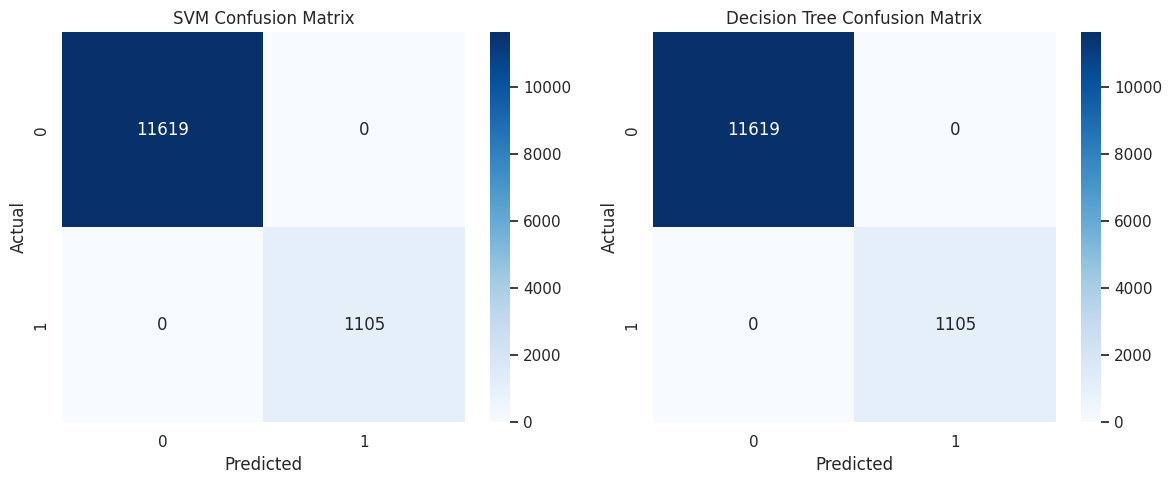

In [26]:
# 8.3 Visualization
# Confusion Matrix for SVM
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, svm_y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Confusion Matrix for Decision Tree
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, dt_y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

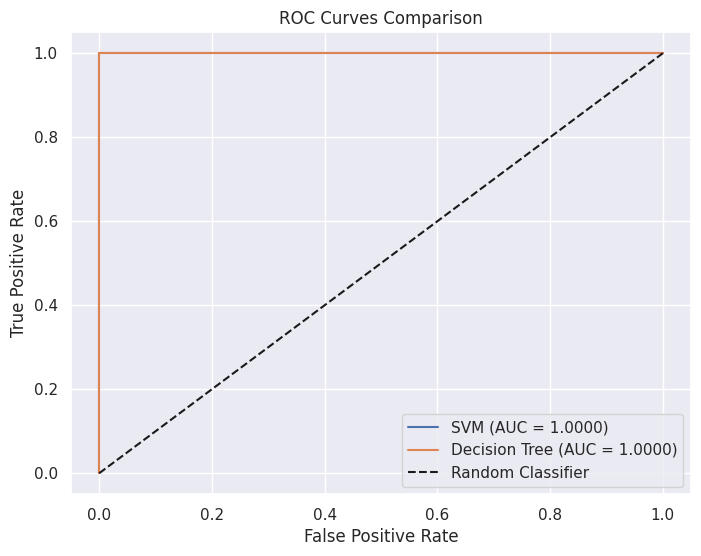

In [27]:
# ROC Curve Comparison
plt.figure(figsize=(8, 6))

# SVM ROC curve
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_pred_proba)
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_roc_auc:.4f})')

# Decision Tree ROC curve
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_y_pred_proba)
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_roc_auc:.4f})')

# Random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

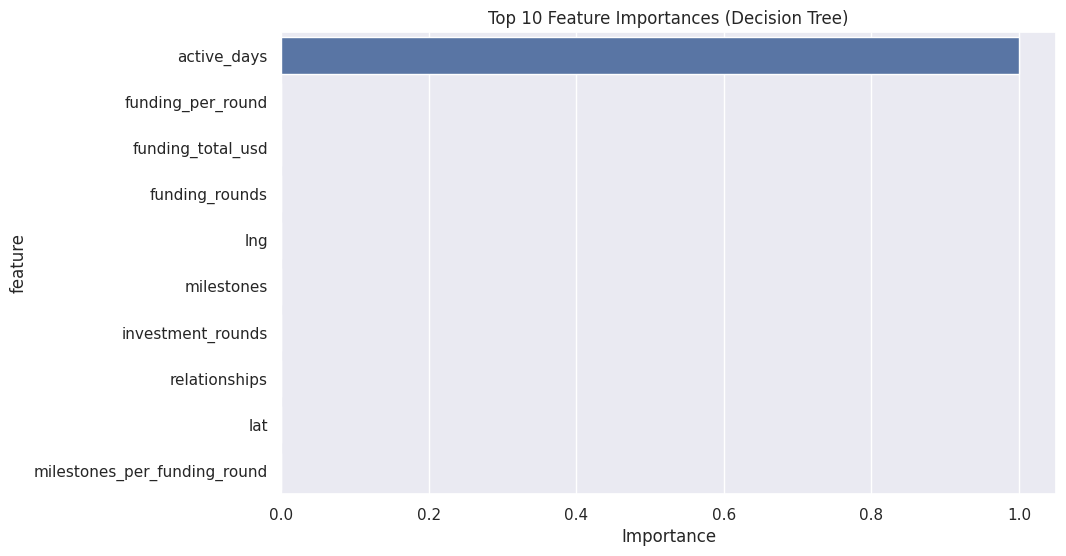

Top 10 Most Important Features:
                        feature  importance
9                   active_days         1.0
1             funding_per_round         0.0
0             funding_total_usd         0.0
2                funding_rounds         0.0
3                           lng         0.0
5                    milestones         0.0
4             investment_rounds         0.0
6                 relationships         0.0
7                           lat         0.0
8  milestones_per_funding_round         0.0


In [28]:
# Feature Importance (Decision Tree)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 10 most important features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.xlabel('Importance')
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

## 9. Model Comparison Summary

In [29]:
# Cross-Validation Scores
svm_cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=3, scoring='accuracy')
dt_cv_scores = cross_val_score(best_dt, X_train, y_train, cv=3, scoring='accuracy')

print("Cross-Validation Scores:")
print(f"SVM: {svm_cv_scores.mean():.4f} (+/- {svm_cv_scores.std() * 2:.4f})")
print(f"Decision Tree: {dt_cv_scores.mean():.4f} (+/- {dt_cv_scores.std() * 2:.4f})")

Cross-Validation Scores:
SVM: 1.0000 (+/- 0.0000)
Decision Tree: 1.0000 (+/- 0.0000)


Model Comparison:
           Model  Accuracy  ROC-AUC  CV Accuracy Mean  CV Accuracy Std
0            SVM       1.0      1.0               1.0              0.0
1  Decision Tree       1.0      1.0               1.0              0.0


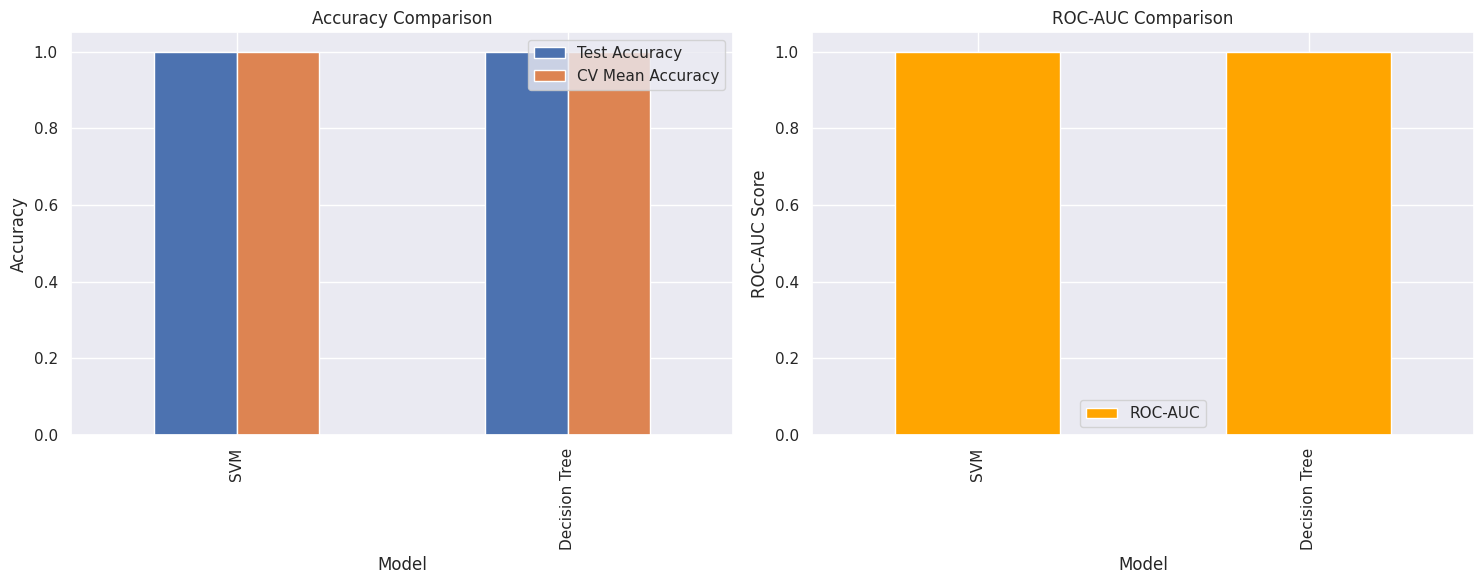

In [30]:
# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['SVM', 'Decision Tree'],
    'Accuracy': [svm_accuracy, dt_accuracy],
    'ROC-AUC': [svm_roc_auc, dt_roc_auc],
    'CV Accuracy Mean': [svm_cv_scores.mean(), dt_cv_scores.mean()],
    'CV Accuracy Std': [svm_cv_scores.std(), dt_cv_scores.std()]
})

print("Model Comparison:")
print(comparison_df)

# Plot comparison
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
comparison_df.plot(x='Model', y=['Accuracy', 'CV Accuracy Mean'], kind='bar', ax=ax[0])
ax[0].set_title('Accuracy Comparison')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Test Accuracy', 'CV Mean Accuracy'])

# ROC-AUC comparison
comparison_df.plot(x='Model', y='ROC-AUC', kind='bar', ax=ax[1], color='orange')
ax[1].set_title('ROC-AUC Comparison')
ax[1].set_ylabel('ROC-AUC Score')

plt.tight_layout()
plt.show()

In [31]:
# Determine the best model
if svm_accuracy > dt_accuracy:
    best_model_name = "SVM"
    best_model = best_svm
    best_model_accuracy = svm_accuracy
else:
    best_model_name = "Decision Tree"
    best_model = best_dt
    best_model_accuracy = dt_accuracy

print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {best_model_accuracy:.4f}")

print("\nKey Findings:")
print("1. Data preprocessing included handling missing values, creating new features, and encoding categorical variables")
print("2. Feature selection was performed using multiple methods to identify the most relevant features")
print("3. Both SVM and Decision Tree models were tuned using grid search with cross-validation")
print("4. Performance was evaluated using accuracy, ROC-AUC, and confusion matrices")
print("5. Feature importance analysis was performed for the Decision Tree model")

Best Model: Decision Tree
Best Accuracy: 1.0000

Key Findings:
1. Data preprocessing included handling missing values, creating new features, and encoding categorical variables
2. Feature selection was performed using multiple methods to identify the most relevant features
3. Both SVM and Decision Tree models were tuned using grid search with cross-validation
4. Performance was evaluated using accuracy, ROC-AUC, and confusion matrices
5. Feature importance analysis was performed for the Decision Tree model


In [33]:
# Save the best model (optional)
import joblib
joblib.dump(best_model, '/content/drive/My Drive/best_startup_model.pkl')
joblib.dump(scaler, '/content/drive/My Drive/feature_scaler.pkl')
print("Best model and scaler saved successfully!")

Best model and scaler saved successfully!
